# Mod 5 Project - Supervised Learning

## Intro

In this project I will be utilizing supervised learning methods to construct a predictive model that estimates whether a patient is likely to be readmitted in the future and other discharge outcomes for inpatients being treated for diabetes. The goal of this model will be to provide hospitals with a better understanding of which diagnoses work best for keeping the patient out of readmission.

## Libraries

Below you will see the Python libraries needed to conduct this exercise.

Some libraries of note are: 
- XX and YY used for data visualization.
- sklearn, a library with many ML packages.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import itertools
import re
import shap

from sklearn import svm, tree
from sklearn.decomposition import PCA
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, classification_report, roc_auc_score, recall_score, precision_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from xgboost import XGBClassifier

from IPython.display import Image
from pydotplus import graph_from_dot_data

import warnings
warnings.filterwarnings("ignore")

## The data

### Obtain/Sourcing

The dataset selected for this project come from the Center for Clinical and Translational Research at Virginia Commonwealth University. Data was sourced from the UC Irvine Machine Learning Repository and can be found here: https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008. The data represent 10 years (1999 - 2008) of clinical care at 130 US hospitals and integrated delivery networks. It includes over 50 features representing patient and hospital outcomes. The data exhibit encounters that satisfy the following criteria:

- It is an inpatient encounter (a hospital admission).
- It is a diabetic encounter, that is, one during which any kind of diabetes was entered to the system as a diagnosis.
- The length of stay was at least 1 day and at most 14 days.
- Laboratory tests were performed during the encounter.
- Medications were administered during the encounter.

The data contains such attributes as patient number, race, gender, age, admission type, time in hospital, medical specialty of admitting physician, number of lab test performed, HbA1c test result, diagnosis, number of medication, diabetic medications, number of outpatient, inpatient, and emergency visits in the year before the hospitalization, etc.

A full list of feature descriptions can be found here: https://drive.google.com/file/d/1SSeT_sWLBoluq-24teF5BQ4lwMkWxWHU/view?usp=sharing

Value ID mapping for the variables admission_type_id, discharge_disposition_id, and admission_source_id can be found here: https://drive.google.com/file/d/19amgd_HmmsoUIr2TCmSpnkD9fWQqVOTE/view?usp=sharing

The target variable will be 'readmitted', which classifies whether the patient was readmitted within 30 days, after 30 days had passed, or there was no record of readmission.

In [2]:
df = pd.read_csv('diabetic_data.csv')
df.head(2)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30


### Scrub/Cleaning

I'll be following the OSEMN process on this project to Obtain, Scrub, Explore, Model, and Interpret the data. Now that I have obtained the data I will scrub it and put the values into a format Python can work with.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
encounter_id                101766 non-null int64
patient_nbr                 101766 non-null int64
race                        101766 non-null object
gender                      101766 non-null object
age                         101766 non-null object
weight                      101766 non-null object
admission_type_id           101766 non-null int64
discharge_disposition_id    101766 non-null int64
admission_source_id         101766 non-null int64
time_in_hospital            101766 non-null int64
payer_code                  101766 non-null object
medical_specialty           101766 non-null object
num_lab_procedures          101766 non-null int64
num_procedures              101766 non-null int64
num_medications             101766 non-null int64
number_outpatient           101766 non-null int64
number_emergency            101766 non-null int64
number_inpatient            10176

In [4]:
df.readmitted.value_counts()

NO     54864
>30    35545
<30    11357
Name: readmitted, dtype: int64

In [5]:
df.isna().sum()

encounter_id                0
patient_nbr                 0
race                        0
gender                      0
age                         0
weight                      0
admission_type_id           0
discharge_disposition_id    0
admission_source_id         0
time_in_hospital            0
payer_code                  0
medical_specialty           0
num_lab_procedures          0
num_procedures              0
num_medications             0
number_outpatient           0
number_emergency            0
number_inpatient            0
diag_1                      0
diag_2                      0
diag_3                      0
number_diagnoses            0
max_glu_serum               0
A1Cresult                   0
metformin                   0
repaglinide                 0
nateglinide                 0
chlorpropamide              0
glimepiride                 0
acetohexamide               0
glipizide                   0
glyburide                   0
tolbutamide                 0
pioglitazo

I can see that I don't have any N/A values, but in the preview of the data I could see that there were character values ('?') in the weight column, so I will likely experience other columns with 'missing information' values.

From the Feature Description table (linked above) I understand that I am missing 97% of the values for weight, 53% of values for the feature identifying the medical specialty of the admitting physician, 52% of the values describing the payer code for the medical insurance/coverage of the patient, and 2% of the Race feature.

In spite of having this information, I will run a check on all feature contents and deal with missing values accordingly below.

In [6]:
cols = [i for i in df.columns]
for col in cols:
    print(df[col].value_counts())

96210942     1
89943846     1
384306986    1
94650156     1
83156784     1
2674482      1
281345844    1
193616274    1
355508024    1
165973818    1
125278944    1
420873188    1
157241154    1
161161032    1
174855390    1
134950734    1
154128210    1
96993108     1
122064144    1
297770840    1
382612616    1
165134172    1
108244830    1
210578766    1
443842340    1
151469730    1
289146210    1
154590960    1
145948404    1
176328594    1
            ..
249722520    1
111830682    1
126506652    1
80193186     1
186881700    1
147162726    1
263120844    1
249665124    1
151295556    1
113303472    1
73909806     1
422050106    1
13655088     1
168523320    1
296140568    1
98784828     1
157333056    1
280536642    1
130655706    1
190162530    1
107017800    1
103828530    1
176744010    1
172279374    1
297285200    1
74454612     1
208073976    1
166229592    1
38340702     1
77856768     1
Name: encounter_id, Length: 101766, dtype: int64
88785891     40
43140906     28
2319

Name: number_outpatient, dtype: int64
0     90383
1      7677
2      2042
3       725
4       374
5       192
6        94
7        73
8        50
10       34
9        33
11       23
13       12
12       10
22        6
18        5
16        5
19        4
20        4
14        3
15        3
21        2
25        2
76        1
54        1
24        1
28        1
29        1
37        1
42        1
46        1
64        1
63        1
Name: number_emergency, dtype: int64
0     67630
1     19521
2      7566
3      3411
4      1622
5       812
6       480
7       268
8       151
9       111
10       61
11       49
12       34
13       20
14       10
15        9
16        6
19        2
17        1
18        1
21        1
Name: number_inpatient, dtype: int64
428       6862
414       6581
786       4016
410       3614
486       3508
427       2766
491       2275
715       2151
682       2042
434       2028
780       2019
996       1967
276       1889
38        1688
250.8     1680
599       1595


Takeaways:
- Encounter_Id is unique, meaning each visit to the hospital was separately identified.
- Patient_nbr was not unique, meaning some patients were readmitted, up to 40 times.
- 2,273 cases of Race not being identified. I will either drop those 2% of data or reclassify to 'Not Specified'
- 3 cases of unknown gender. Those will be dropped.
- Majority of patients are above the age of 50.
- Weight will likely be dropped as a feature.
- Given the high uncertainty in the payer_code and medical_specialty, those features will also be dropped.
- Diag_3 has '?' values, which could indicate the presence of those in the other diag features.
- Given the low occurrence of some of the drugs (e.g. metformin-pioglitazone), I will likely drop some of those as features.

In [7]:
#generate a copy of the data
data = df

I wanted to see how dropping the duplicate patient numbers would impact the results on the target variable. There was some concern that patients with more than one visit would disproportionately have target values that were not 'NO'. That does not seem to be the case. 39% of the duplicate valued patients had a readmit result of 'No', compared to the 54% of all data that make up the 'No' readmit. For now I will move forward with all data, but might model without duplicate values to see if there is a significant difference.

In [8]:
#Drop the rows where Race is not specified
data = data[data['race'] != '?']

#Drop the rows where Gender is not specified
data = data[data['gender'] != 'Unknown/Invalid']

#Drop the columns with a significant number of missing values
data = data.drop(['weight', 'payer_code', 'medical_specialty'], axis=1)

In [9]:
#There are only 10 instances of Newborn admissions type so I will drop those
data = data[data['admission_type_id'] != 4]

#Recode admission type to better group them
data['admission_type_id'] = [1 if i in [5, 6, 8] #N/A
                             else 2 if i in [1, 2, 7] #Emergency 
                             else 3 #Elective
                             for i in data['admission_type_id']] 

data = data[data['admission_type_id'] != 1] #drop the N/As

#Recode the discharge disposition column to better group them.
data['discharge_disposition_id'] = [1 if i in [18, 25] #N/A
                                    else 2 if i in [3, 4, 5, 6, 9, 10, 12, 22, 
                                                    23, 24, 27, 28] #Continued care
                                    else 3 if i in [11, 19, 20] #Expired
                                    else 4 if i in [1, 7] #No additional care
                                    else 5 if i in [2, 8, 15, 16, 17] #Short term care
                                    else 6 #Hospice
                                    for i in data['discharge_disposition_id']] 

data = data[data['discharge_disposition_id'] != 1] #drop the NAs
data = data[data['discharge_disposition_id'] != 3] #drop the Expired cases as they cannot be readmitted

#Use the Label Encoder to categorize the target variable
lbe = LabelEncoder()
data['readmitted'] = lbe.fit_transform(data['readmitted'])
data['readmitted'] = data['readmitted'].apply(lambda x: 'No_readmit' if x >1 
                                              else 'Readmit')
data['readmitted'] = data['readmitted'].astype('category')
data.readmitted.value_counts()

No_readmit    44469
Readmit       39600
Name: readmitted, dtype: int64

In [10]:
data.shape

(84069, 47)

Below is a list of all of the drugs included in the dataset. Because the number of patients that actually experience a change in any one of these medication prescriptions is so low, I am electing to generate a new variable, drugchange. If the patient experienced a change ('Up', 'Down') in any of these medications, they will receive a +1 on the drug change category. You will see in the output that most (79k) patients did not experience a change in their prescriptions.

In [11]:
drugs = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 
         'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 
         'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 
         'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 
         'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 
         'metformin-rosiglitazone', 'metformin-pioglitazone']

for drug in drugs:
    drugname = str(drug) + 'temp'
    data[drugname] = data[drug].apply(lambda x: 0 if (x == 'No' or 
                                                      x == 'Steady') else 1)
data['drugchange'] = 0
for drug in drugs:
    drugname = str(drug) + 'temp'
    data['drugchange'] = data['drugchange'] + data[drugname]
    del data[drugname]

data['drugchange'].value_counts()

0    79752
1     4010
2      296
3       10
4        1
Name: drugchange, dtype: int64

There is little reason to keep all of the individual medications as they affect so few patients. Instead, we'll just focus on whether they had a change to their prescriptions.

In [12]:
data = data.drop(['admission_source_id', 'diag_1', 'diag_2', 'diag_3', 
                  'max_glu_serum', 'metformin', 'repaglinide', 'nateglinide', 
                  'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 
                  'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 
                  'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 
                  'examide', 'citoglipton', 'glyburide-metformin', 
                  'glipizide-metformin', 'glimepiride-pioglitazone', 
                  'metformin-rosiglitazone', 'metformin-pioglitazone', 
                  'diabetesMed'], axis=1)

In [13]:
#I wanted to recode age as a continuous variable
#First I needed to control for patient id, because I have a few repeat patients
dd = data.drop_duplicates('patient_nbr', keep='first')

#I then wanted to make a function that would read through the binned ages and 
#return a random int between the high and low value
def get_age(i):
    #this reads the 1:3 characters of e.g. '[10-20)'
    a = dd.age[i][1:3]
    #This controls for the '[0-10)' bin
    if a == '0-':
        a = 0
    else:
        a = int(a)
    b = a + 10
    c = np.random.randint(a, b)
    #c is going to give us a random integer between e.g. (10, 20)
    return c
#This generates a new column with an integer of age in the df that is
#controlled for duplicate patient ids
dd['age1'] = [get_age(i) for i in dd.index]
#I just want the patient id and the age
dd = dd.drop(dd.columns[2:20],axis=1)
dd = dd.drop('encounter_id', axis=1)
#I merge the two data frames together
data = data.merge(dd, how='left', left_on='patient_nbr', right_on='patient_nbr')
data = data.drop('age', axis=1)
data = data.drop('change', axis=1)

### Exploring

In [14]:
data.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'admission_type_id',
       'discharge_disposition_id', 'time_in_hospital', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'number_diagnoses', 'A1Cresult',
       'insulin', 'readmitted', 'drugchange', 'age1'],
      dtype='object')

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84069 entries, 0 to 84068
Data columns (total 19 columns):
encounter_id                84069 non-null int64
patient_nbr                 84069 non-null int64
race                        84069 non-null object
gender                      84069 non-null object
admission_type_id           84069 non-null int64
discharge_disposition_id    84069 non-null int64
time_in_hospital            84069 non-null int64
num_lab_procedures          84069 non-null int64
num_procedures              84069 non-null int64
num_medications             84069 non-null int64
number_outpatient           84069 non-null int64
number_emergency            84069 non-null int64
number_inpatient            84069 non-null int64
number_diagnoses            84069 non-null int64
A1Cresult                   84069 non-null object
insulin                     84069 non-null object
readmitted                  84069 non-null category
drugchange                  84069 non-null int64
ag

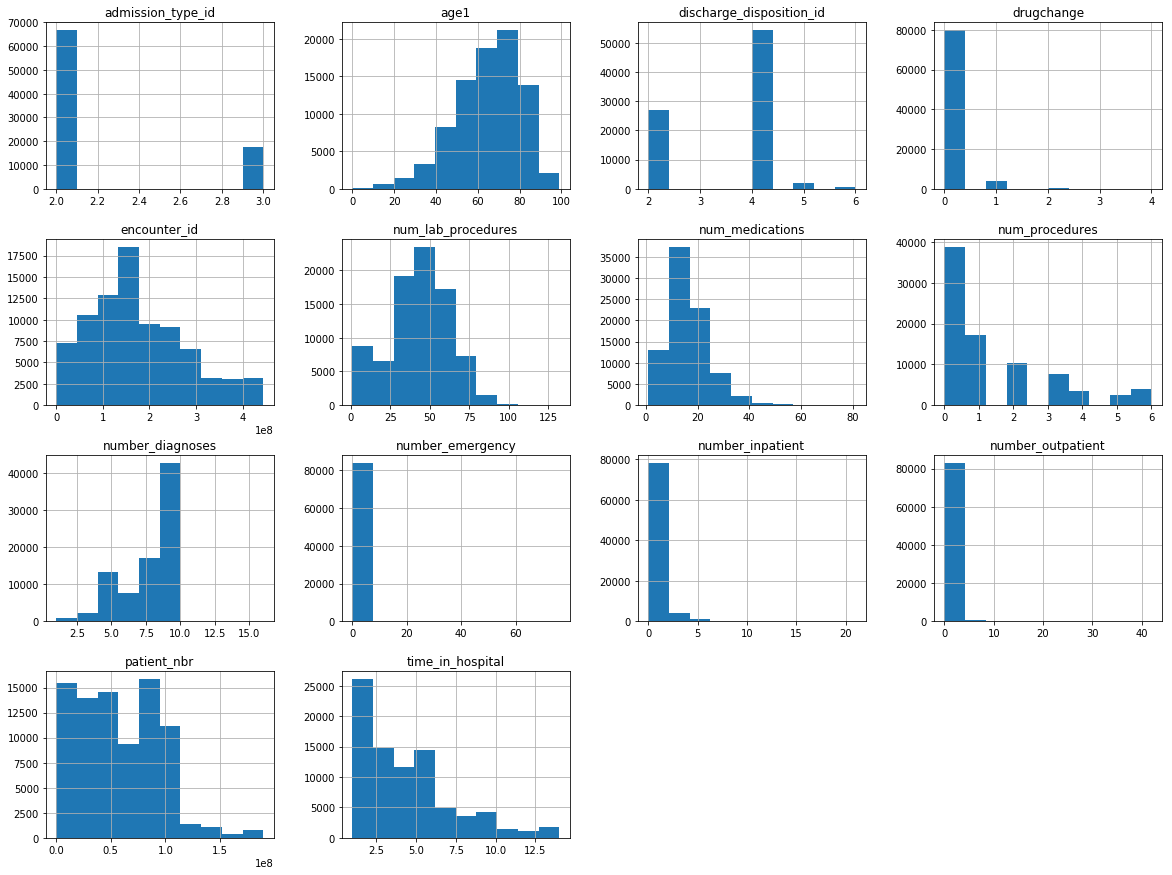

In [16]:
feat = data
feat.hist(figsize=(20,15));

There is not a lot of normality in the distributions of the variables. Many, especially the emergency, inpatient, and outpatient visit variables are zero heavy, which could lead to large, non-zero values having great influence on the model.

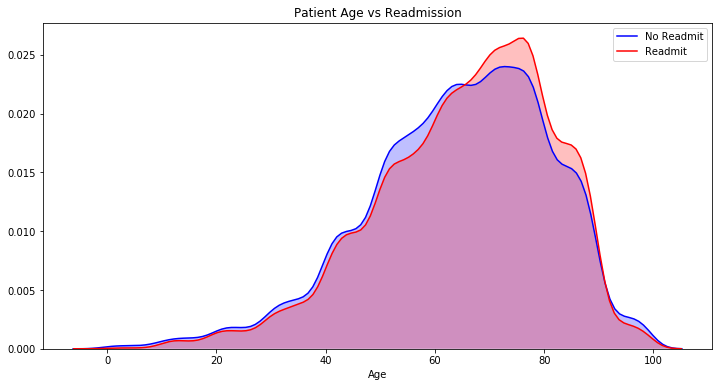

In [17]:
#Plot age against readmission rate to determine whether older 
#patients have a greater propensity to return to the hospital
fig = plt.figure(figsize=(12,6))
ax = sns.kdeplot(data.loc[(data['readmitted'] == 'No_readmit'), 'age1'], 
                 color='b', shade=True, label='No Readmit')
ax = sns.kdeplot(data.loc[(data['readmitted'] == 'Readmit'), 'age1'], 
                 color='r', shade=True, label='Readmit')
ax.set(xlabel='Age')
plt.title('Patient Age vs Readmission');

Older patients seem to have a slight propensity to be readmitted more frequently than younger patients, but it is very slight. Additional analysis could include segmenting the data by the target classes and determining if there is a difference in population means.

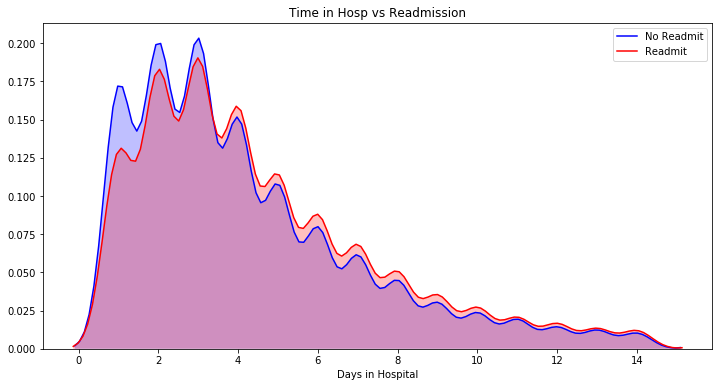

In [18]:
#Here I check to see if there is any potential relationship between a longer
#stay in the hospital and the return rate
fig = plt.figure(figsize=(12,6))
ax = sns.kdeplot(data.loc[(data['readmitted'] == 'No_readmit'), 'time_in_hospital'], 
                 color='b', shade=True, label='No Readmit')
ax = sns.kdeplot(data.loc[(data['readmitted'] == 'Readmit'), 'time_in_hospital'], 
                 color='r', shade=True, label='Readmit')
ax.set(xlabel='Days in Hospital')
plt.title('Time in Hosp vs Readmission');

There is little discernible difference between readmit rates based on the length of a hospital stay, but it looks like patients who have a shorter stay are slightly less likely to be readmitted.

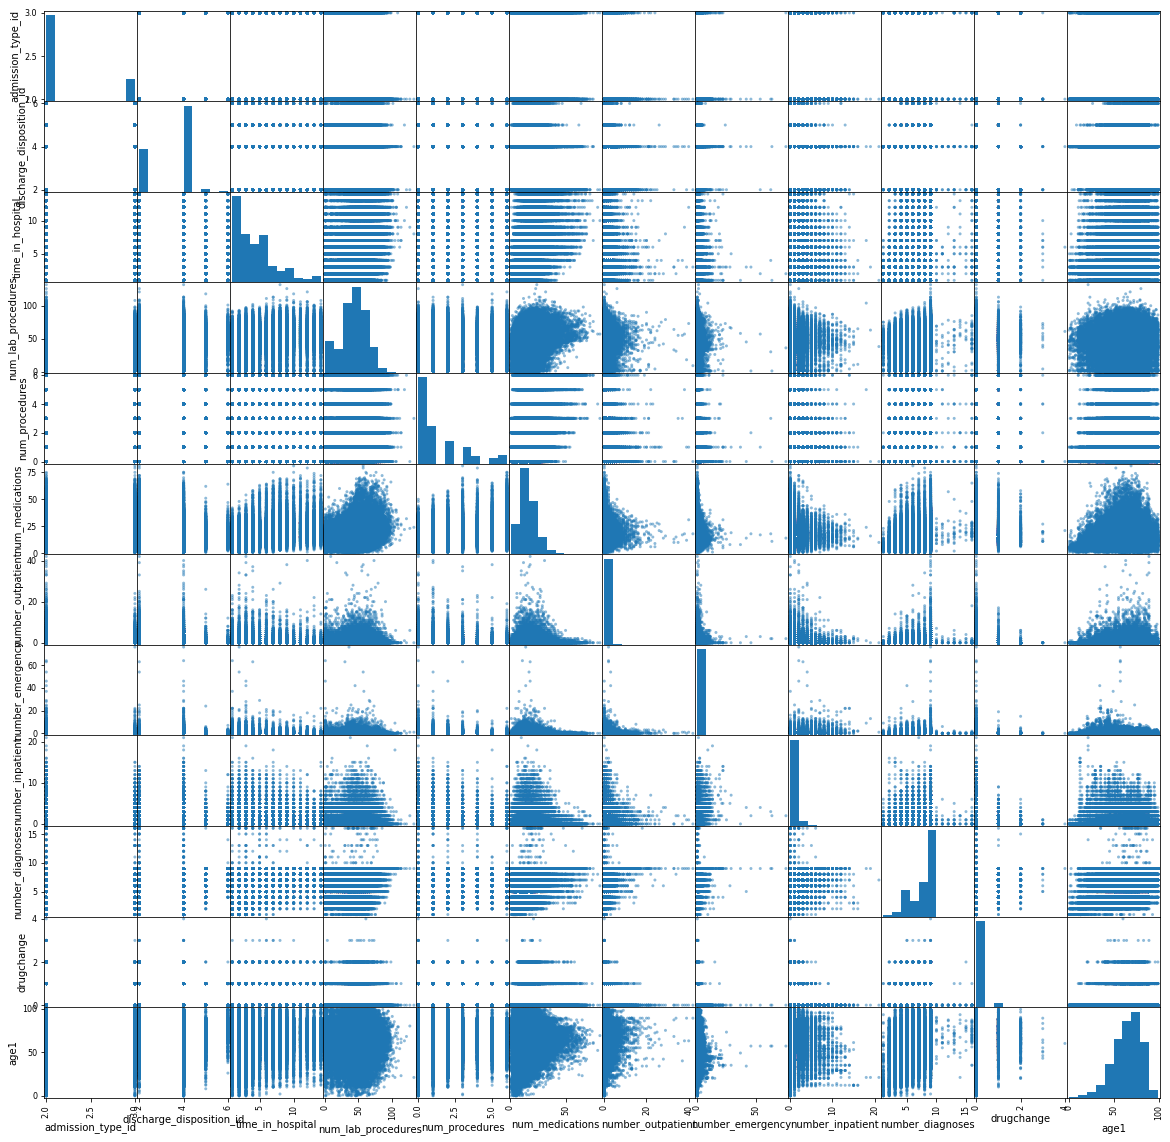

In [19]:
#Here I will run a scatter matrix on the data to inspect some of the relationships
pd.plotting.scatter_matrix(data[['race', 'gender', 'admission_type_id', 
                                 'discharge_disposition_id', 'time_in_hospital', 
                                 'num_lab_procedures', 'num_procedures', 
                                 'num_medications', 'number_outpatient', 
                                 'number_emergency', 'number_inpatient', 
                                 'number_diagnoses', 'A1Cresult', 'insulin', 
                                 'drugchange', 'age1']], figsize= [20,20])

plt.show();

There is a lot going on in this view, but I notice the inverse relationship that the number of medications a patient is on seems to have with the number of inpatient stays they had in the last year.

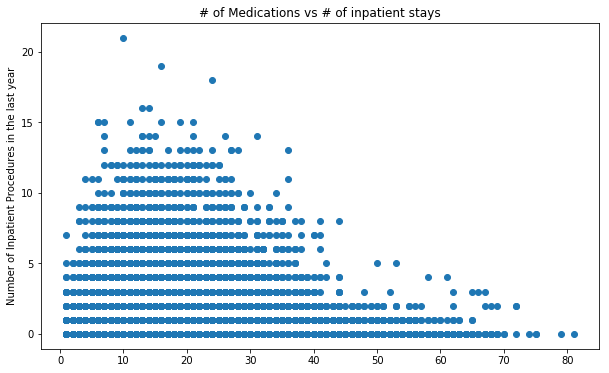

In [20]:
fig = plt.figure(figsize=(10,6))
ax = plt.scatter(data['num_medications'], data['number_inpatient'])
plt.title('# of Medications vs # of inpatient stays')
plt.ylabel('Number of Inpatient Procedures in the last year');

While the relationship is weak, it does appear there is some inverse relationship between the number of medications a patient is on and the number of inpatient visits they had in the previous year.

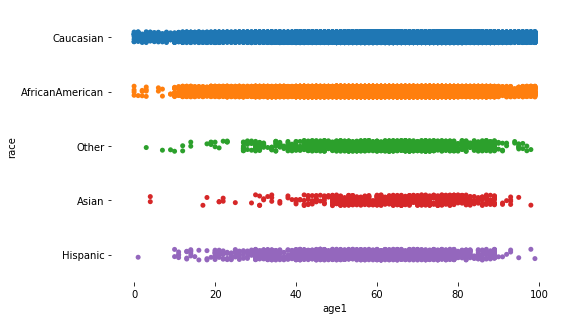

In [21]:
#Here I plotted age against race to see if there is any indication of who the
#patients are. It appears the majority of patients under 40 are not Asian or 
#Hispanic. This could speak to something about how Hispanic and Asian 
#patients experience diabetes.
fig, ax = plt.subplots(figsize = (8,5))
sns.despine(bottom=True, left=True)

sns.stripplot(x='age1', y='race', data=data, dodge=True, jitter=True)
plt.show()

I will now generate categorical variables. I will drop the first dummy for each categorical variable to avoid multicollinearity of the features.

In [22]:
# Of those, these are all of the variables that are categorical.
a = ['race', 'gender', 'admission_type_id', 'discharge_disposition_id', 
     'A1Cresult', 'insulin']

#Generating a dictionary where the key is the column name and the value
#is a DF of dummy variable columns, dropping the first instance to avoid
#multicollinearity
b = {}
for i in a:
    b[i] = pd.get_dummies(data[i], prefix=i, drop_first=True)

#drop the columns I created dummys for
data = data.drop(a, axis=1)

#merging the dummy DFs to the original data frame and dropping the index column
#from each merge
for key in b:
    data = pd.merge(data, 
                    b[key], 
                    how='outer', 
                    left_on=data.index,
                    right_on=b[key].index)
    data = data.drop('key_0', axis=1)

#view the columns to ensure I completed the dummy columns correctly
data.columns

Index(['encounter_id', 'patient_nbr', 'time_in_hospital', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'number_diagnoses',
       'readmitted', 'drugchange', 'age1', 'race_Asian', 'race_Caucasian',
       'race_Hispanic', 'race_Other', 'gender_Male', 'admission_type_id_3',
       'discharge_disposition_id_4', 'discharge_disposition_id_5',
       'discharge_disposition_id_6', 'A1Cresult_>8', 'A1Cresult_None',
       'A1Cresult_Norm', 'insulin_No', 'insulin_Steady', 'insulin_Up'],
      dtype='object')

In [23]:
#Setting the df index to 'encounter_id', which is our unique identifier
data = data.set_index('encounter_id')
data = data.dropna(axis=0)

#I know from earlier there were repeat patients in the group. To remove the bias
#of patients who are known to return to the hospital, I drop the duplicate values
#I also drop the 'patient_nbr' here because it doesn't tell us anything
dd = data.drop_duplicates('patient_nbr', keep='first')
dd = dd.drop('patient_nbr', axis=1)
dd.readmitted.value_counts()

No_readmit    35276
Readmit       24132
Name: readmitted, dtype: int64

In [24]:
print(dd.shape)
dd.head()

(59408, 26)


,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,readmitted,drugchange,...,admission_type_id_3,discharge_disposition_id_4,discharge_disposition_id_5,discharge_disposition_id_6,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,insulin_No,insulin_Steady,insulin_Up
encounter_id,,,,,,,,,,,,,,,,,,,,,
149190,3,59,0,18,0,0,0,9,Readmit,0,...,0,1,0,0,0,1,0,0,0,1
64410,2,11,5,13,2,0,1,6,No_readmit,0,...,0,1,0,0,0,1,0,1,0,0
500364,2,44,1,16,0,0,0,7,No_readmit,0,...,0,1,0,0,0,1,0,0,0,1
16680,1,51,0,8,0,0,0,5,No_readmit,0,...,0,1,0,0,0,1,0,0,1,0
35754,3,31,6,16,0,0,0,9,Readmit,0,...,0,1,0,0,0,1,0,0,1,0


Run an additional check for multicollinearity by plotting a heat map

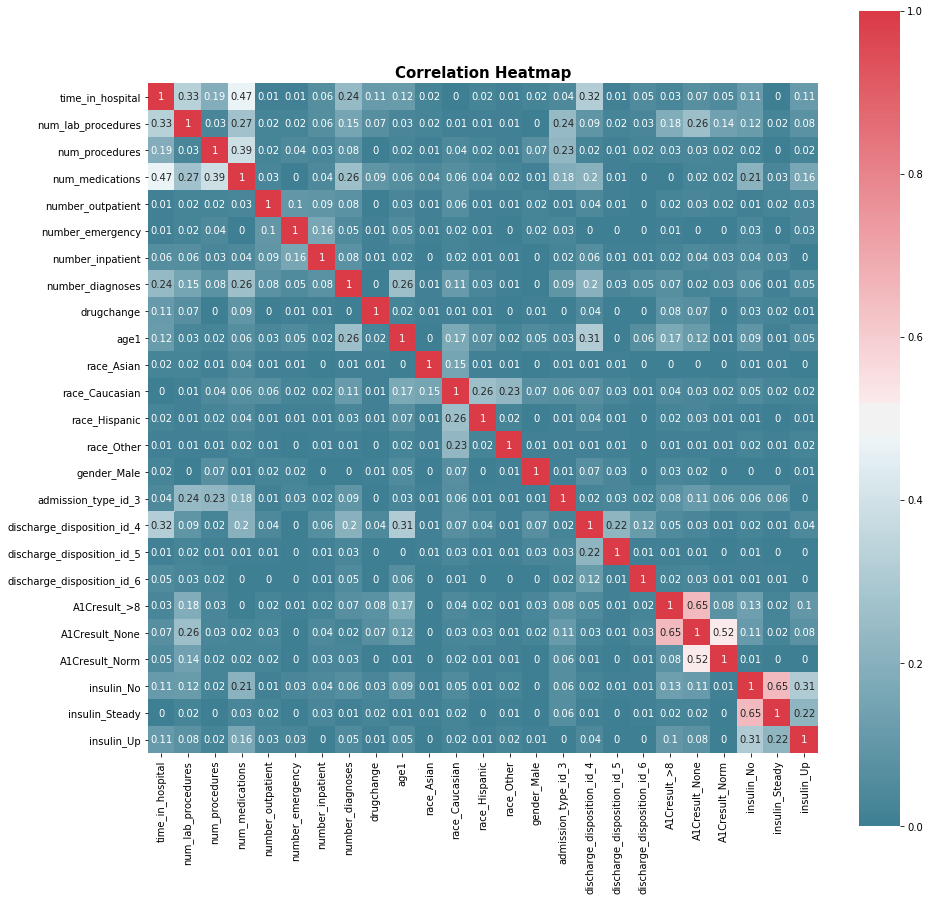

In [25]:
correlation = abs(round(dd.corr(), 2))
f, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(correlation, annot = True, square=True, cmap =sns.diverging_palette(220, 10, as_cmap=True))
plt.title('Correlation Heatmap',fontweight='bold',fontsize=15)
plt.show();

There were no variables with multicollinearity > .75, which is the standard cutoff so I will not drop any features

### Final Features

The final data set contains 59,408 instances and 13 variables/25 features that we are left with include the following:
- time_in_hospital (continuous): a range from 1 to 14 days, measuring the length of the inpatient stay
- num_lab_procedures (continuous): the number of lab tests performed for the patient during the encounter
- num_medications (continuous): the number of distinct generic name medicines administered during the encounter
- number_outpatient (continuous): the number of outpatient visits the patient had in the year preceding the encounter
- number_emergency (continuous): the number of emergency room visits the patient had in the year preceding the encounter
- number inpatient (continuous): the number of inpatient visits the patient had in the year preceding the encounter
- drugchange (continuous): a generated variable that counts the number of changes to any of 24 medications
- age1 (continuous): a generated random age for the patient - a random integer was selected from a 10-year range provided by the original categorical bin from the data set
- race (categorical): a dummy variable for one of Asian, Caucasian, Hispanic, Other; African American was the dropped dummy variable
- admission_type_id (categorical): a dummy variable where the option is either '3', representing 'Elective' admission, or not, which would identify the encounter as an 'Emergency' admission
- discharge_disposition_id (categorical): a dummy variable for either 3, 4, 5, 6; 2 was the dropped dummy variable. 2-6 represent 'Continued Care', 'Expired', 'No additional care', 'Short term care', and 'Hospice' respectively
- A1Cresults (categorical): a dummy variable for test results that show whether a patient's levels of blood glucose over the past 3 months has not changed, remained normal, increased >8%, or increased >7%
- Insulin (categorical): a dummy variable to indicate whether insulin was not prescribed, or whether it was held steady, increased, or decreased

## Modeling

### Train-Test Split

I will now split the data into training and testing sets for the modeling. I will have a testing set that is 25% of the data. I am using Random Seed 123 so that results are reproducible.

In [26]:
y = dd.readmitted
X = dd.drop('readmitted', axis=1)

X = X.reset_index()
features = [i for i in X.columns[1:11]]

#Here I am using a Standard Scaler to scale the continuous varaibles in the data.
#This will normalize some of the features that have a wider range (age) for those
#with a lower range (drugchange)
a = X[X.columns[1:11]]
a = StandardScaler().fit_transform(a)
b = pd.DataFrame(data=a, columns=features)
X = X.drop(features, axis=1)
X = X.merge(b, left_index=True, right_index=True)
X = X.set_index('encounter_id')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

print(y_train.value_counts())

print(y_test.value_counts())

No_readmit    26399
Readmit       18157
Name: readmitted, dtype: int64
No_readmit    8877
Readmit       5975
Name: readmitted, dtype: int64


The class balance is about 60/40 - this is not terribly severe, so there is no need to correct for class imbalance.

### Building Baseline Models

I will now construct baseline models for classification. They are baseline because I am not selecting any parameters for these models at this time, so they are not optimized for performance.

#### Logistic Regression

I will start with a basic logistic regression model

In [27]:
#Generate a copy of the training and testing set for each model
lrX_train = X_train
lrX_test = X_test
lry_train = y_train
lry_test = y_test

In [28]:
#The first model will be Logistic Regression

#Instantiate a LogReg classifier and fit the training sets

#fit_intercept is set to False because we don't want a constant added to the 
#decision function. C is large to boost regularization and penalize misclasses.
#solver is 'sag' or Stochastic Average Gradient decent solver
logreg = LogisticRegression(fit_intercept=False, C=1e12, solver='sag')
model_log = logreg.fit(lrX_train, lry_train)
print(model_log)

#setting the predicted train and test sets
lry_hat_train = logreg.predict(lrX_train)
lry_hat_test = logreg.predict(lrX_test)

#because the target is currently set to 'Readmit' and 'No_readmit' I need
#to code them as 0 and 1.
lry_train = np.array([1 if i == 'Readmit' else 0 for i in lry_train])
lry_hat_train = np.array([1 if i == 'Readmit' else 0 for i in lry_hat_train])


#Calculate the residuals for the training set
residuals = np.abs(lry_train - lry_hat_train)
print('------------------------------------\tTraining Accuracy')
print(pd.Series(residuals).value_counts())
print(pd.Series(residuals).value_counts(normalize=True))


lry_test = np.array([1 if i == 'Readmit' else 0 for i in lry_test])
lry_hat_test = np.array([1 if i == 'Readmit' else 0 for i in lry_hat_test])

#Calculate the residuals for the testing set
residuals = np.abs(lry_test - lry_hat_test)
print('------------------------------------\tTesting Accuracy')
print(pd.Series(residuals).value_counts())
print(pd.Series(residuals).value_counts(normalize=True))

LogisticRegression(C=1000000000000.0, class_weight=None, dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='sag', tol=0.0001, verbose=0,
                   warm_start=False)
------------------------------------	Training Accuracy
0    27579
1    16977
dtype: int64
0    0.618974
1    0.381026
dtype: float64
------------------------------------	Testing Accuracy
0    9356
1    5496
dtype: int64
0    0.629949
1    0.370051
dtype: float64


As we can see above, the training data had ~62% accuracy and the test data had ~63% accuracy

In [29]:
#I will want to plot many confusion matricies, so this is a function to do so

#The function will take in a confusion matrix call, a list of the class names,
#an argument on whether the data should be normalized, title defaults to 
#'Confusion matrix', and a default blue color map.

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    # Check if normalize is set to True
    # If so, normalize the raw confusion matrix before visualizing
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    #This generates a 2D display
    plt.imshow(cm, cmap=cmap)
    
    # Add title and axis labels 
    plt.title(title) 
    plt.ylabel('True label') 
    plt.xlabel('Predicted label')
    
    # Add appropriate axis scales
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    # Text formatting
    fmt = '.2f' if normalize else 'd'
    # Add labels to each cell
    thresh = cm.max() / 2.
    # Here I iterate through the confusion matrix and append labels to our visualization 
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')
    
    # Add a legend
    plt.colorbar()
    plt.show() 

Normalized confusion matrix
[[0.90582404 0.09417596]
 [0.77991632 0.22008368]]


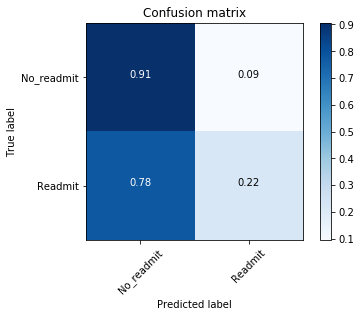

In [30]:
#all the possible values of y
class_names = set(y) 

#generate values for the CM
cnf_mat_logreg = confusion_matrix(lry_test, lry_hat_test) 

#plot
plot_confusion_matrix(cnf_mat_logreg, classes=class_names, normalize=True)

#### Decision Tree

Next moving onto a Decision Tree classifier. Decision trees will default to optimize their splits on the Gini impurity and because no parameters have been specified, the base model will be as large as it needs.

In [31]:
dtX_train = X_train
dtX_test = X_test
dty_train = y_train
dty_test = y_test

#Same as the LR model, I need to recode the target classes
dty_train = np.array([1 if i == 'Readmit' else 0 for i in dty_train])
dty_test = np.array([1 if i == 'Readmit' else 0 for i in dty_test])

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=123, splitter='best')

Baseline Training Accuracy: 99.99%
Baseline Test Accuracy: 54.3%

Normalized confusion matrix
[[0.60110398 0.39889602]
 [0.5432636  0.4567364 ]]


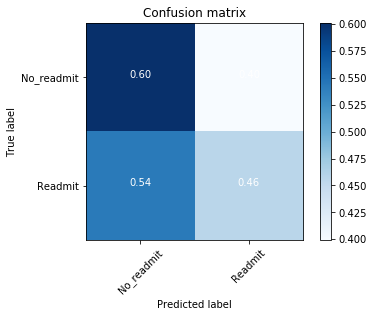

In [32]:
#Starting with a baseline classifier (parameter optimization will come later)
#and only setting the random state of the model.
dtclassifier = DecisionTreeClassifier(random_state=123)
dtclassifier.fit(dtX_train, dty_train)
print(dtclassifier.fit(dtX_train, dty_train))

#This is the accuracy score of the baseline training model
training_accuracy = dtclassifier.score(dtX_train, dty_train)

#This is the accuracy score of the baseline test model
test_accuracy = dtclassifier.score(dtX_test, dty_test)

print("")
print('Baseline Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Baseline Test Accuracy: {:.4}%'.format(test_accuracy * 100))
print("")

#This is a list of the amount of variance each feature seems to explain in the model
print(dtclassifier.feature_importances_)


#print a confusion matrix
dty_hat_test = dtclassifier.predict(dtX_test)
class_names = set(y)
cnf_mat_dt = confusion_matrix(dty_test, dty_hat_test)
plot_confusion_matrix(cnf_mat_dt, classes=class_names, normalize=True)

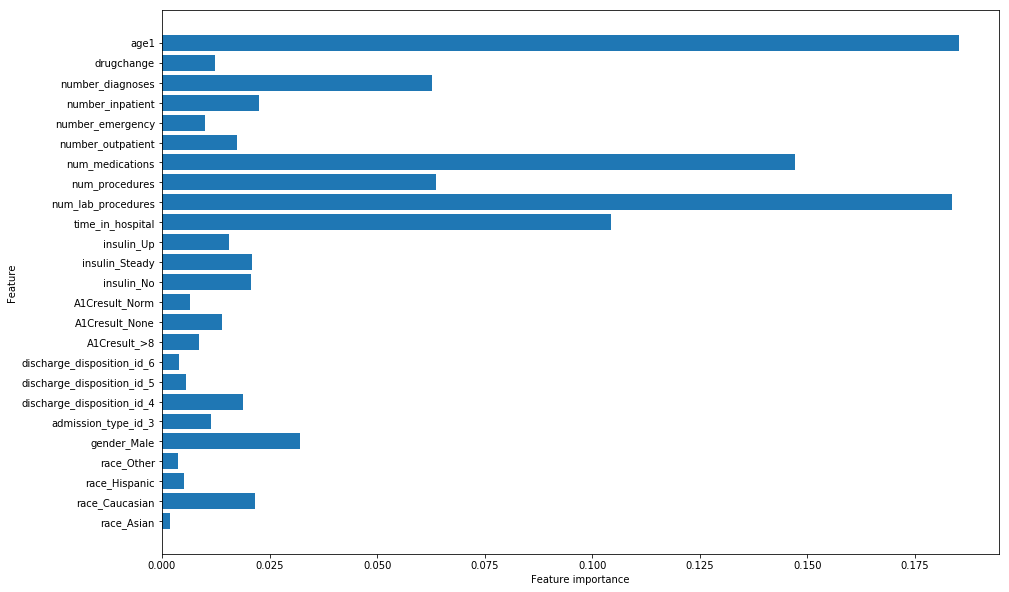

In [33]:
#This function allows a plpt of the feature importance of a given classifier
#and the training data set. Feature importance allows us insight as to which 
#features provide the most information/explain the most variance in the data.

def plot_feature_importances(model, train):
    n_features = train.shape[1]
    plt.figure(figsize=(15,10))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

plot_feature_importances(dtclassifier, dtX_train)

In [34]:
#I will manually regroup the features that were split into categories to allow
#for a more intuitive visual on the Decision Tree feature importance.

race = 0.0021399 + 0.02176485 + 0.00444596 + 0.00398766
discharge_disposition = 0.01925185 + 0.00545241 + 0.00416932
A1Cresult = 0.0093778 + 0.01488382 + 0.00668669
insulin = 0.02275626 + 0.02178649 + 0.0143247


feature_weights = {'race': race, 'gender': 0.03111519, 'admission type': 0.01124202, 
                   'discharge disposition': discharge_disposition, 'A1Cresult': A1Cresult, 
                   'insulin': insulin, 'time in hospital': 0.1017033, 
                   'num lab proc': 0.19397076, 'num proc': 0.06339208, 
                   'num medications': 0.14477524, 'num outpatient': 0.01658202, 
                   'num emergency': 0.00948527, 'num inpatient': 0.02253114, 
                   'num diagnoses': 0.0588033 , 'drug change': 0.01202122, 
                   'age': 0.18335074}

graphdf = pd.DataFrame({'y': [i for i in feature_weights.keys()], 'x': [i for i in feature_weights.values()]})
graphdf = graphdf.sort_values('x')

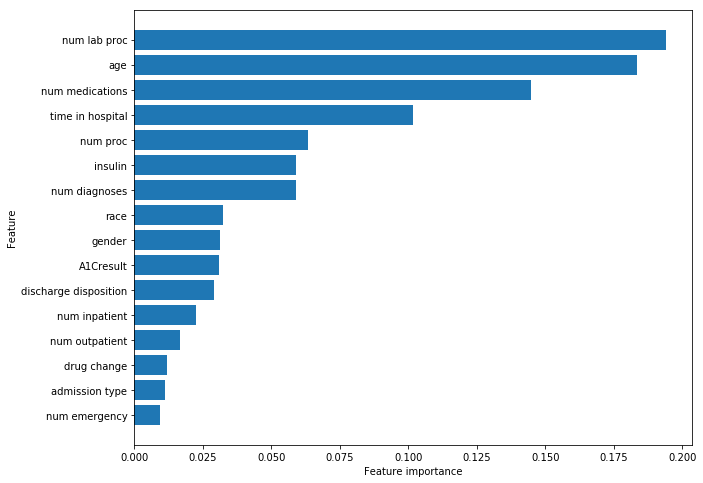

In [35]:
plt.figure(figsize=(10,8))
plt.barh(graphdf.y, graphdf.x, align='center') 
plt.xlabel('Feature importance')
plt.ylabel('Feature');

As we can see, the number of lab procedures conducted while the patient was in the hospital, patient age, and the number of medications the patient is prescribed account for a little more than half of all variance in the model.

#### Bagged Tree

Bagged trees combine bootstrapping and aggregation to take subsets of the training data out of the fitting process. It does this multiple times, each time generating a tree that is blinded from some subset of the training data. This will allow for some features to show varying levels of importance as they are/aren't used in the trees.

BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=None,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort='deprecated',
                                                        random_state=123,
 

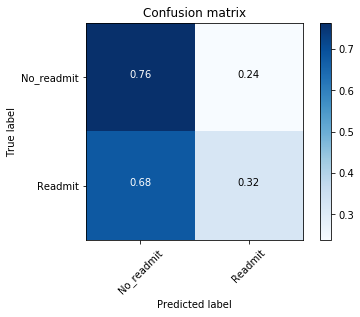

In [37]:
btX_train = X_train
btX_test = X_test
bty_train = y_train
bty_test = y_test

#Same as the LR model, I need to recode the target classes
bty_train = np.array([1 if i == 'Readmit' else 0 for i in bty_train])
bty_test = np.array([1 if i == 'Readmit' else 0 for i in bty_test])

#Generate a default Bagging Classifier, selecting a Decision Tree as the base 
#estimator. The default number of base estimators that will be generated is 10.
#The estimator's random state was set for reproducibility. N jobs specifies how
#many processors should run in parallel for the fit and predict calculations
btclassifier = BaggingClassifier(DecisionTreeClassifier(random_state=123), n_jobs=-1)
btclassifier.fit(btX_train, bty_train)
print(btclassifier.fit(btX_train, bty_train))

#This is the accuracy score of the baseline training model
training_accuracty = btclassifier.score(btX_train, bty_train)

#This is the accuracy score of the baseline test model
test_accuracy = btclassifier.score(btX_test, bty_test)

print("")
print('Baseline Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Baseline Test Accuracy: {:.4}%'.format(test_accuracy * 100))
print("")

#print a confusion matrix
bty_hat_test = btclassifier.predict(btX_test)
class_names = set(y)
cnf_mat_bt = confusion_matrix(bty_test, bty_hat_test)
plot_confusion_matrix(cnf_mat_bt, classes=class_names, normalize=True)

#### Random Forest

A Random Forest fits a number of classifiers (default to Decision Trees) on subsamples of the data. First the model will bag the data, as with the bagging classifier, selecting some number of rows with replacement (Bootstrapping) from the dataset. It will take these subsets of the dataset and further pair them down by selecting n-features from the bagged data. The model will then train the tree on the modified dataset and then use the same n-features from the out of bag data as an internal test on that tree. When new data is introduced, each tree in the forest "votes" for the prediction it believes is correct and the majority wins.

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=123, verbose=0,
                       warm_start=False)

Baseline Training Accuracy: 99.99%
Baseline Test Accuracy: 61.42%

Normalized confusion matrix
[[0.79621494 0.20378506]
 [0.65623431 0.34376569]]


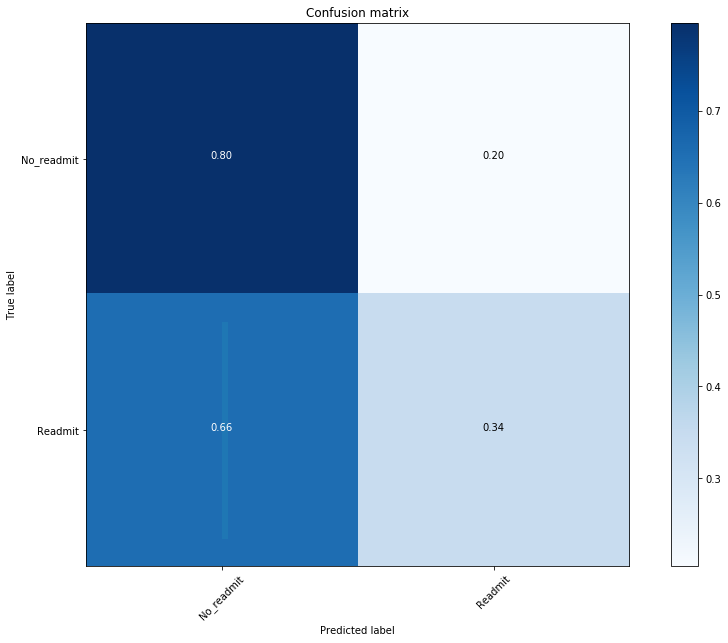

In [38]:
rfX_train = X_train
rfX_test = X_test
rfy_train = y_train
rfy_test = y_test

#Same as the LR model, I need to recode the target classes
rfy_train = np.array([1 if i == 'Readmit' else 0 for i in rfy_train])
rfy_test = np.array([1 if i == 'Readmit' else 0 for i in rfy_test])

#Generate a baseline RandomForest Classifier. Default estimator is always a 
#Decision Tree classifier. The number of estimators defaults to 100. The 
#samples are being drawn with replacement because bootstrap defaults to True.
rfclassifier = RandomForestClassifier(random_state=123, n_jobs=-1)
print(rfclassifier.fit(rfX_train, rfy_train))

#This is the accuracy score of the baseline training model
training_accuracy = rfclassifier.score(rfX_train, rfy_train)

#This is the accuracy score of the baseline testing model
test_accuracy = rfclassifier.score(rfX_test, rfy_test)

print("")
print('Baseline Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Baseline Test Accuracy: {:.4}%'.format(test_accuracy * 100))
print("")

plot_feature_importances(rfclassifier, rfX_train)

#plot a confusion matrix for the full forest
rfy_hat_test = rfclassifier.predict(rfX_test)
class_names = set(y)
cnf_mat_rf = confusion_matrix(rfy_test, rfy_hat_test)
plot_confusion_matrix(cnf_mat_rf, classes=class_names, normalize=True)

Below is an example of what would happen if you set the max number of features to 5 and the max depth of the trees to 2 for a small number of trees, to better visualize how feature importance can shift in the trees

In [39]:
rfclassifier2 = RandomForestClassifier(n_estimators= 10, max_features=5, max_depth=2, random_state=123)
rfclassifier2.fit(rfX_train, rfy_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=2, max_features=5,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)

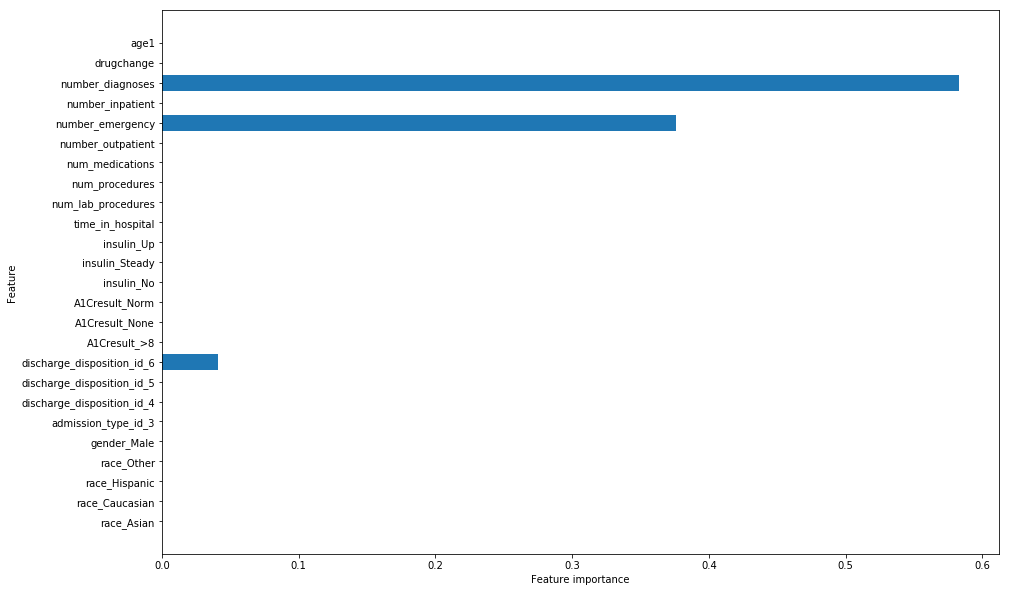

In [40]:
plot_feature_importances(rfclassifier2.estimators_[0], rfX_train)

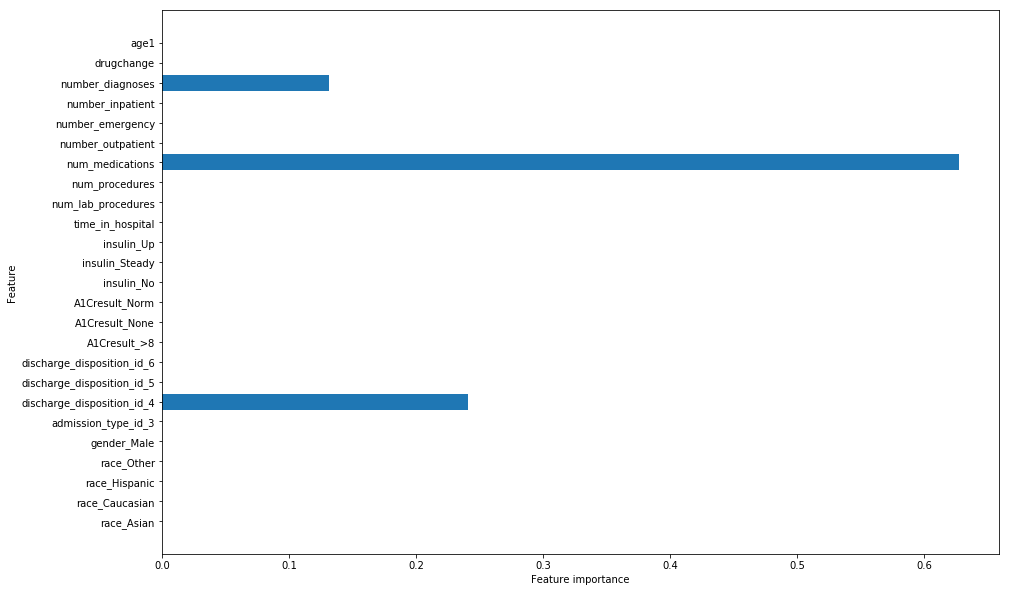

In [41]:
plot_feature_importances(rfclassifier2.estimators_[5], rfX_train)

#### Adaptive Boosting

Adaptive Boosting, or AdaBoost is a boosting method used on weak learners. Data is randomly sampled with replacement. For each bag, each instance is assigned a weight used to select the instance for the next classifier. If the model gets the class of the instance incorrect, the weight increases and vice versa. Because correctly identified instances have decreased weight, the easy to identify instances will quickly become less relevant and the models will more often select instances more often misclassified to develop trees with splits that drill down to better identify the tricky cases. Some trees in AdaBoost models can be large and some might just be one split.


Baseline Training Accuracy: 62.51%
Baseline Test Accuracy: 63.04%

Normalized confusion matrix
[[0.88509632 0.11490368]
 [0.74794979 0.25205021]]


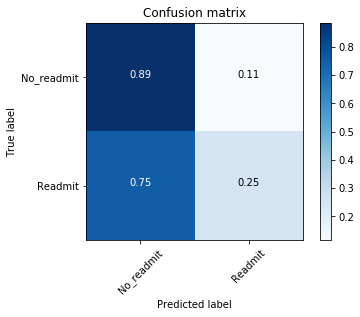

In [42]:
adX_train = X_train
adX_test = X_test
ady_train = y_train
ady_test = y_test

#Same as the LR model, I need to recode the target classes
ady_train = np.array([1 if i == 'Readmit' else 0 for i in ady_train])
ady_test = np.array([1 if i == 'Readmit' else 0 for i in ady_test])

adclassifier = AdaBoostClassifier(random_state=123)
adclassifier.fit(adX_train, ady_train)

#This is the accuracy score of the baseline training model
training_accuracy = adclassifier.score(adX_train, ady_train)

#This is the accuracy score of the baseline testing model
test_accuracy = adclassifier.score(adX_test, ady_test)

print("")
print('Baseline Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Baseline Test Accuracy: {:.4}%'.format(test_accuracy * 100))
print("")

#plot a confusion matrix for the full forest
ady_hat_test = adclassifier.predict(adX_test)
class_names = set(y)
cnf_mat_ad = confusion_matrix(ady_test, ady_hat_test)
plot_confusion_matrix(cnf_mat_ad, classes=class_names, normalize=True)

#### XGBoost

XGBoost, or eXtreme Gradient Boosting is the last classifier I will implement. Gradient boosting is similar to Adaptive boosting, but instead of assigning weights to the instances we want the model to focus on, it instead will calculate the residuals from each model, compute a loss function from the residuals, and then calculate the gradient for the loss. The gradients and the loss are used as predictors to train the next tree. XGBoost is the highest performing version of gradient boosting right now - one of its benefits is that it parallelizes the construction of trees across all CPU cores during construction to optimize computing power.


Baseline Training Accuracy: 63.03%
Baseline Test Accuracy: 63.22%

Normalized confusion matrix
[[0.88847584 0.11152416]
 [0.74845188 0.25154812]]


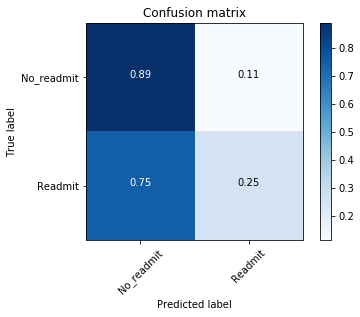

In [43]:
xgbX_train = X_train
xgbX_test = X_test
xgby_train = y_train
xgby_test = y_test

#Same as the LR model, I need to recode the target classes
xgby_train = np.array([1 if i == 'Readmit' else 0 for i in xgby_train])
xgby_test = np.array([1 if i == 'Readmit' else 0 for i in xgby_test])


#I use regex (regular expression) to find and replace the bracket characters
#with an underscore so the XGBoost classifier can read the data
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
xgbX_train.columns = [regex.sub("_", col) if any(x in str(col) for x in 
                                              set(('[', ']', '<'))) else col 
                   for col in xgbX_train.columns.values]
xgbX_test.columns = [regex.sub("_", col) if any(x in str(col) for x in 
                                              set(('[', ']', '<'))) else col 
                   for col in xgbX_test.columns.values]



#Similar to the GridSearchCV methods, I will develop a baseline model before 
#tuning the parameters using GridSearchCV

# Instantiate and fit XGBClassifier
xgbclassifier = XGBClassifier(random_state=123)
xgbclassifier.fit(xgbX_train, xgby_train)

#This is the accuracy score of the baseline training model
training_accuracy = xgbclassifier.score(xgbX_train, xgby_train)

#This is the accuracy score of the baseline testing model
test_accuracy = xgbclassifier.score(xgbX_test, xgby_test)

print("")
print('Baseline Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Baseline Test Accuracy: {:.4}%'.format(test_accuracy * 100))
print("")

#plot a confusion matrix for the XGBoost model
xgby_hat_test = xgbclassifier.predict(xgbX_test)
class_names = set(y)
cnf_mat_xgb = confusion_matrix(xgby_test, xgby_hat_test)
plot_confusion_matrix(cnf_mat_xgb, classes=class_names, normalize=True)

#### Results of the baseline models

In [44]:
#See below of the classification report tables for each of the baseline models
#I have also included the AUC score for each classifier
dic = {'LR': [lry_test, lry_hat_test], 
       'DT': [dty_test, dty_hat_test], 
       'BT': [bty_test, bty_hat_test], 
       'RF': [rfy_test, rfy_hat_test],
       'AD': [ady_test, ady_hat_test], 
       'XGB': [xgby_test, xgby_hat_test]}

for key in dic.keys():
    print(key+'\t')
    # Check the AUC for predictions
    false_positive_rate, true_positive_rate, thresholds = roc_curve(dic[key][0], dic[key][1])
    roc_auc = auc(false_positive_rate, true_positive_rate)
    print('\nAUC is :{0}'.format(round(roc_auc, 2)))
    print(classification_report(dic[key][0], dic[key][1]))
    print('-------------------------------------------------------')

LR	

AUC is :0.56
              precision    recall  f1-score   support

           0       0.63      0.91      0.75      8877
           1       0.61      0.22      0.32      5975

    accuracy                           0.63     14852
   macro avg       0.62      0.56      0.53     14852
weighted avg       0.62      0.63      0.58     14852

-------------------------------------------------------
DT	

AUC is :0.53
              precision    recall  f1-score   support

           0       0.62      0.60      0.61      8877
           1       0.44      0.46      0.45      5975

    accuracy                           0.54     14852
   macro avg       0.53      0.53      0.53     14852
weighted avg       0.55      0.54      0.54     14852

-------------------------------------------------------
BT	

AUC is :0.54
              precision    recall  f1-score   support

           0       0.63      0.76      0.69      8877
           1       0.48      0.32      0.38      5975

    accuracy    

### Model Optimization - Pipelines with GridSearchCV

#### PCA

The data set has a high number of features (25) and as we saw in the initial Random Forest classifier, there were many features that explained less than 5% of the model variance. High dimensionality increases the spread of the data and leads to fewer observations across the regions of space the data lies in.

To reduce the noise, I will apply Principal Component Analysis (PCA), which aims to reduce the number of dimensions in the dataset while capturing as much of the variance as possible. The general approach for PCA is to:
- Recenter the features by subtracting the mean - this repositions the data around the origin without changing the data points absolute distance from one another
- Calculate the covariance matrix for the centered dataset
- Calculate the eigenvectors of the covariance matrix
- Project the data into the new feature space by multiplying the eigenvectors by the mean-centered features

In [45]:
#Reintroduce the dataset and scale it using Standard Scaler
X = dd.drop('readmitted', axis=1)

a = X[X.columns[1:11]]
a = StandardScaler().fit_transform(a)
b = pd.DataFrame(data=a, columns=features)
X = X.drop(features, axis=1)
X = X.merge(b, left_index=True, right_index=True)


#The baseline classifier for PCA is a decision tree. Given the feature imporance
#graphs from the Random Forest Analysis, I selected a low number of features to
#test
pca_1 = PCA(n_components=5)
pca_2 = PCA(n_components=6)
pca_3 = PCA(n_components=7)

principalComponents = pca_1.fit_transform(X)
principalComponents = pca_2.fit_transform(X)
principalComponents = pca_3.fit_transform(X)

print(np.sum(pca_1.explained_variance_ratio_))
print(np.sum(pca_2.explained_variance_ratio_))
print(np.sum(pca_3.explained_variance_ratio_))

0.9487605987050325
0.9821769064276683
0.9945563219264587


In [46]:
#By selecting just 6 features I am still able to capture ~98% of the variance
#in the model
pca = PCA(n_components=6)
principalComponents = pca.fit_transform(X)
print(np.sum(pca.explained_variance_ratio_))

0.9821769064276683


#### Pipeline with GridSearchCV

GridSearchCV or GridSearch Cross Validation is a method used to help tune the parameters of a classifier model. It allows for a parameter grid search, which iterates through a dictionary of potential model parameter specifications, noting model performance of each combination, while also implementing K-fold cross validation on the model. 

Cross validation is the practice of spliting the data into k groups. One of the k groups is held as a testing data set while the other k-1 groups are used as a training data set. The holdout group is then used as a testing set; the evaluation score is kept while the model is discarded. This process is repeated until each of the k groups has been used as the test set.

Pipelines are a useful way of conducting all of the steps in the above process at once. We are able to introduce a Scaler to transform the data, pair the data down to the 6 optimal features we determined through PCA, and then introduce feature selection with a grid search to determine which parameters maximize the desired score.

I initialize this work by starting with the unscaled dataset, setting the parameters for the pipeline specifications, establishing parameter grids for the classifiers, and then running 3-fold cross validation on each of the baseline models. I set the score optimization to be 'roc_auc' because I would like to maximize the roc-auc score.

In [47]:
y = dd.readmitted
X = dd.drop('readmitted', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

In [48]:
pipe_dt = Pipeline([('scaler', StandardScaler()), 
                    ('pca', PCA(n_components=6)),
                    ('clf', DecisionTreeClassifier(random_state=123))])

pipe_bt = Pipeline([('scaler', StandardScaler()), 
                    ('pca', PCA(n_components=6)),
                    ('clf', BaggingClassifier(random_state=123))])

pipe_rf = Pipeline([('scaler', StandardScaler()), 
                    ('pca', PCA(n_components=6)),
                    ('clf', RandomForestClassifier(random_state=123))])

pipe_ad = Pipeline([('scaler', StandardScaler()), 
                    ('pca', PCA(n_components=6)),
                    ('clf', AdaBoostClassifier(random_state=123))])

pipe_xg = Pipeline([('scaler', StandardScaler()), 
                    ('pca', PCA(n_components=6)),
                    ('clf', XGBClassifier(random_state=123))])

In [49]:
#Parameter grids:
dt_grid = {'clf__criterion': ['gini', 'entropy'],
           'clf__max_depth': [3, 5, 7],
           'clf__min_samples_leaf': [10, 15],
           'clf__min_samples_split': [5, 10, 20]}

bt_grid = {'clf__n_estimators': [80, 100, 120],
           'clf__max_samples': [.25, .5, .75, 1]}

rf_grid = {'clf__n_estimators': [80, 100, 120],
           'clf__criterion': ['gini', 'entropy'],
           'clf__max_depth': [10, 15, 20],
           'clf__min_samples_leaf': [10, 20],
           'clf__min_samples_split': [10, 20]}

ad_grid = {'clf__n_estimators': [10, 15, 20],
           'clf__learning_rate': [1.0, 0.5, 0.1]}

xg_grid = {'clf__learning_rate': [0.01, 0.05, 0.1],
           'clf__max_depth': [10, 15],
           'clf__min_child_weight': [5, 10],
           'clf__subsample': [0.5, 0.4],
           'clf__n_estimators': [40, 50, 100]}

In [50]:
gs_dt = GridSearchCV(estimator=pipe_dt,
                     param_grid=dt_grid, 
                     scoring='roc_auc', 
                     cv=3, verbose=False, refit=True, 
                     return_train_score=True)

gs_bt = GridSearchCV(estimator=pipe_bt,
                     param_grid=bt_grid, 
                     scoring='roc_auc', 
                     cv=3, verbose=False, refit=True, 
                     return_train_score=True)

gs_rf = GridSearchCV(estimator=pipe_rf,
                     param_grid=rf_grid, 
                     scoring='roc_auc', 
                     cv=3, verbose=False, refit=True, 
                     return_train_score=True)

gs_ad = GridSearchCV(estimator=pipe_ad,
                     param_grid=ad_grid, 
                     scoring='roc_auc', 
                     cv=3, verbose=False, refit=True, 
                     return_train_score=True)

gs_xg = GridSearchCV(estimator=pipe_xg,
                     param_grid=xg_grid, 
                     scoring='roc_auc', 
                     cv=3, verbose=False, refit=True, 
                     return_train_score=True)

In [52]:
# List of pipelines, List of pipeline names
pipelines = [gs_dt, gs_bt, gs_rf, gs_ad, gs_xg]
pipeline_names = ['Decision Tree','Bagged Tree', 'Random Forest', 'Adaboost', 'XGBoost']

# Loop to fit each of the model pipelines and return the optimal model parameters
for pipe in pipelines:
    print(pipe)
    pipe.fit(X_train, y_train)
    print('\nBest params:\n', pipe.best_params_)
    print("")

GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('pca',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=6, random_state=None,
                                            svd_solver='auto', tol=0.0,
                                            whiten=False)),
                                       ('clf',
                                        DecisionTreeClassifier(ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gini',
                                    

             scoring='accuracy', verbose=False)

Best params:
 {'clf__learning_rate': 0.01, 'clf__max_depth': 10, 'clf__min_child_weight': 10, 'clf__n_estimators': 100, 'clf__subsample': 0.4}



In [54]:
#This is resetting the classifiers to the optimal parameters determined by the
#pipeline construction

dtclassifier = DecisionTreeClassifier(criterion='entropy', max_depth=3, 
                                      min_samples_leaf=15, min_samples_split=20, 
                                      random_state=123)

btclassifier = BaggingClassifier(max_samples=0.25, n_estimators=120, 
                                 random_state=123)

rfclassifier = RandomForestClassifier(criterion='gini', max_depth=10, 
                                      min_samples_leaf=20, min_samples_split=20, 
                                      n_estimators=80, random_state=123)

adclassifier = AdaBoostClassifier(learning_rate=0.5, n_estimators=20, 
                                  random_state=123)

xgbclassifier = XGBClassifier(learning_rate=0.01, max_depth=10, 
                              min_child_weight=10, n_estimators=100, 
                              subsample=0.4, random_state=123)

#### Interpreting model results

I will now inspect the optimized models

In [55]:
#Once again want to bring in my data and scale it

y = dd.readmitted
X = dd.drop('readmitted', axis=1)

X = X.reset_index()
features = [i for i in X.columns[1:11]]

a = X[X.columns[1:11]]
a = StandardScaler().fit_transform(a)
b = pd.DataFrame(data=a, columns=features)
X = X.drop(features, axis=1)
X = X.merge(b, left_index=True, right_index=True)
X = X.set_index('encounter_id')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

In [56]:
#Here I initialized training and testing sets for each of the classifiers

dtX_train = X_train
btX_train = X_train
rfX_train = X_train
adX_train = X_train
xgbX_train = X_train
dtX_test  = X_test
btX_test = X_test
rfX_test = X_test
adX_test = X_test
xgbX_test = X_test
dty_train = y_train
bty_train = y_train
rfy_train = y_train
ady_train = y_train
xgby_train = y_train

#Reclass the target data to 0s and 1s for both training and testing sets
dty_train = np.array([1 if j == 'Readmit' else 0 for j in dty_train])
bty_train = np.array([1 if j == 'Readmit' else 0 for j in bty_train])
rfy_train = np.array([1 if j == 'Readmit' else 0 for j in rfy_train])
ady_train = np.array([1 if j == 'Readmit' else 0 for j in ady_train])
xgby_train = np.array([1 if j == 'Readmit' else 0 for j in xgby_train])

dty_test = y_test
bty_test = y_test
rfy_test = y_test
ady_test = y_test
xgby_test = y_test

dty_test = np.array([1 if j == 'Readmit' else 0 for j in dty_test])
bty_test = np.array([1 if j == 'Readmit' else 0 for j in bty_test])
rfy_test = np.array([1 if j == 'Readmit' else 0 for j in rfy_test])
ady_test = np.array([1 if j == 'Readmit' else 0 for j in ady_test])
xgby_test = np.array([1 if j == 'Readmit' else 0 for j in xgby_test])


xtr = [lrX_train, dtX_train, btX_train, rfX_train, adX_train, xgbX_train]
xte = [lrX_test, dtX_test, btX_test, rfX_test, adX_test, xgbX_test]
ytr = [lry_train, dty_train, bty_train, rfy_train, ady_train, xgby_train]
yte = [lry_test, dty_test, bty_test, rfy_test, ady_test, xgby_test]

In [57]:
#Here I am establishing a model to produce the baseline, training, and testing
#AUC_ROC scores for each of the optimized models.
def evaluate_model(predictions, probs, train_predictions, train_probs, test_labels, train_labels):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    baseline['roc_auc'] = 0.5
    
    results = {}
    results['roc_auc'] = roc_auc_score(test_labels, probs)
    
    train_results = {}
    train_results['roc_auc'] = roc_auc_score(train_labels, train_probs)
    
    for metric in ['roc_auc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 3)} Test: {round(results[metric], 3)} Train: {round(train_results[metric], 3)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(test_labels, [1 for _ in range(len(test_labels))])
    model_fpr, model_tpr, _ = roc_curve(test_labels, probs)
    print("")
    print('AUC: {}'.format(round(auc(model_fpr, model_tpr),3)))
    print("")
    print('-------------------------------')
    
    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 8
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');

LR
Roc_auc Baseline: 0.5 Test: 0.635 Train: 0.626

AUC: 0.635

-------------------------------
DT
Roc_auc Baseline: 0.5 Test: 0.603 Train: 0.592

AUC: 0.603

-------------------------------
BT
Roc_auc Baseline: 0.5 Test: 0.627 Train: 0.967

AUC: 0.627

-------------------------------
RF
Roc_auc Baseline: 0.5 Test: 0.648 Train: 0.672

AUC: 0.648

-------------------------------
AD
Roc_auc Baseline: 0.5 Test: 0.637 Train: 0.628

AUC: 0.637

-------------------------------
XGB
Roc_auc Baseline: 0.5 Test: 0.646 Train: 0.678

AUC: 0.646

-------------------------------


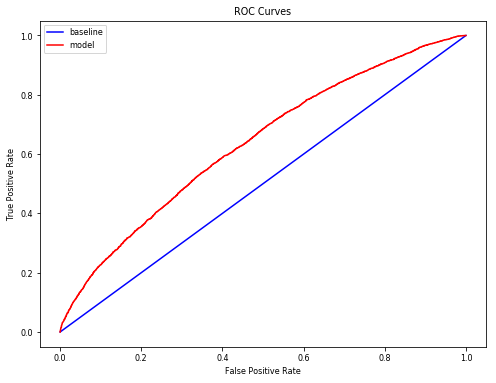

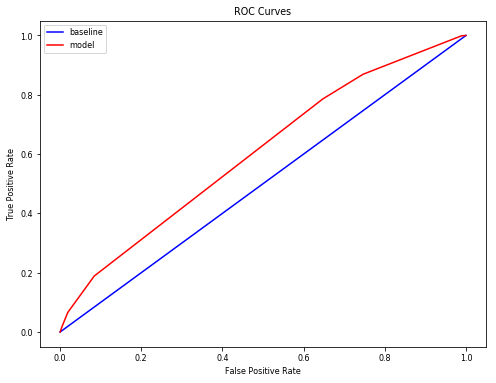

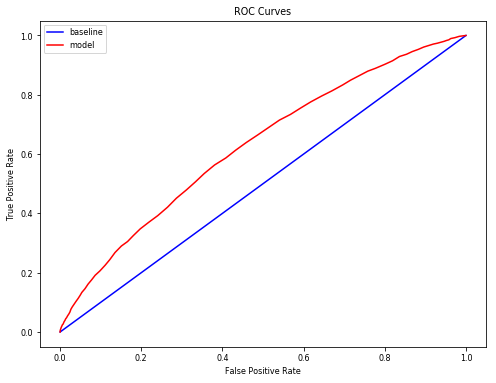

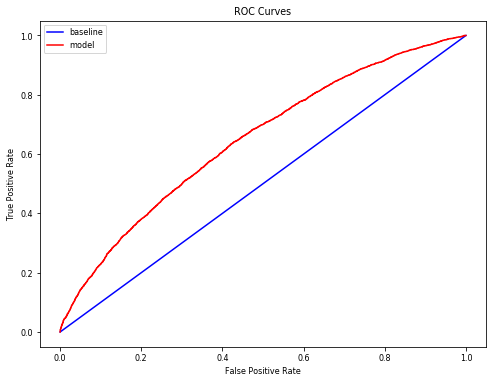

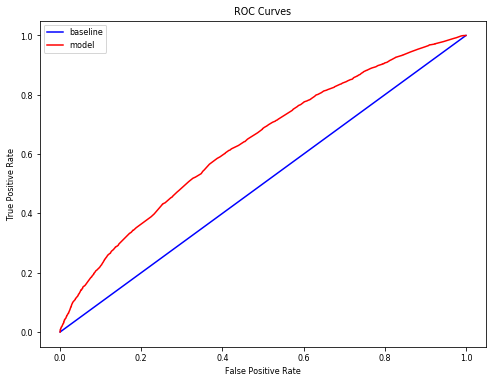

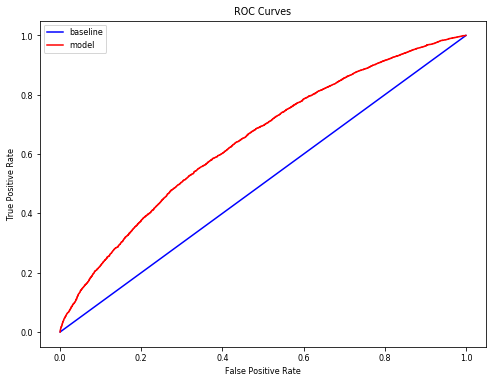

In [58]:
#Here I generate a printout of ROC_AUC scores with the baseline, training, and testing

clfs = [logreg, dtclassifier, btclassifier, rfclassifier, adclassifier, xgbclassifier]
mods = ['LR', 'DT', 'BT', 'RF', 'AD', 'XGB']
for k, clf in enumerate(clfs):
    clf.fit(xtr[k], ytr[k])
    train_proba = clf.predict_proba(xtr[k])[:,1]
    probs = clf.predict_proba(xte[k])[:,1]
    train_predict = clf.predict(xtr[k])
    train_predict = np.array([1 if i == 'Readmit' else 0 for i in train_predict])
    predict = clf.predict(xte[k])
    predict = np.array([1 if i == 'Readmit' else 0 for i in predict])
    print(mods[k])
    evaluate_model(predict, probs, train_predict, train_proba, yte[k], ytr[k])

This shows that, while only slightly better, the Random Forest classifier had slightly better performance than the XGBoosted model. Either of these models would be acceptable to select. There is little overfitting in most of the models, given their close training and testing scores, with the exception of the Bagged Classifier which had a high training score and a much lower testing performance.

A false positive (saying a patient will be readmitted and they never return) has lower cost on the hospital than a false negative (saying a patient will not readmit and they do), when we use the lens that a false positive would only leave a hospital better prepared to deal with more patients; although there could also be costs associated with that - e.g bringing extra doctors on staff. Because the costs are different, I want to evaluate the model by assessing both precision and recall, so I will use the F1 score that has been weighted across both classes.

In [59]:
#I have already reset the classifiers with the optimized parameters, so now I
#will run one final fit on the models with the data

dtclassifier = dtclassifier.fit(dtX_train, dty_train)
btclassifier = btclassifier.fit(btX_train, bty_train)
rfclassifier = rfclassifier.fit(rfX_train, rfy_train)
adclassifier = adclassifier.fit(adX_train, ady_train)
xgbclassifier = xgbclassifier.fit(xgbX_train, xgby_train)

In [66]:
gsdty_hat_test = dtclassifier.predict(dtX_test)
gsbty_hat_test = btclassifier.predict(btX_test)
gsrfy_hat_test = rfclassifier.predict(rfX_test)
gsady_hat_test = adclassifier.predict(adX_test)
gsxgy_hat_test = xgbclassifier.predict(xgbX_test)

dic2 = {'LR': [lry_test, lry_hat_test], 'DT': [dty_test, gsdty_hat_test], 
        'BT': [bty_test, gsbty_hat_test], 'RF': [rfy_test, gsrfy_hat_test], 
        'AD': [ady_test, gsady_hat_test], 'XGB': [xgby_test, gsxgy_hat_test]}

for key in dic2.keys():
    print(key+'\t')
    print(classification_report(dic2[key][0], dic2[key][1]))
    print('-----------------------------------------------------------')

LR	
              precision    recall  f1-score   support

           0       0.63      0.91      0.75      8877
           1       0.61      0.22      0.32      5975

    accuracy                           0.63     14852
   macro avg       0.62      0.56      0.53     14852
weighted avg       0.62      0.63      0.58     14852

-----------------------------------------------------------
DT	
              precision    recall  f1-score   support

           0       0.63      0.92      0.74      8877
           1       0.60      0.19      0.29      5975

    accuracy                           0.62     14852
   macro avg       0.61      0.55      0.52     14852
weighted avg       0.62      0.62      0.56     14852

-----------------------------------------------------------
BT	
              precision    recall  f1-score   support

           0       0.64      0.82      0.72      8877
           1       0.55      0.32      0.41      5975

    accuracy                           0.62     14

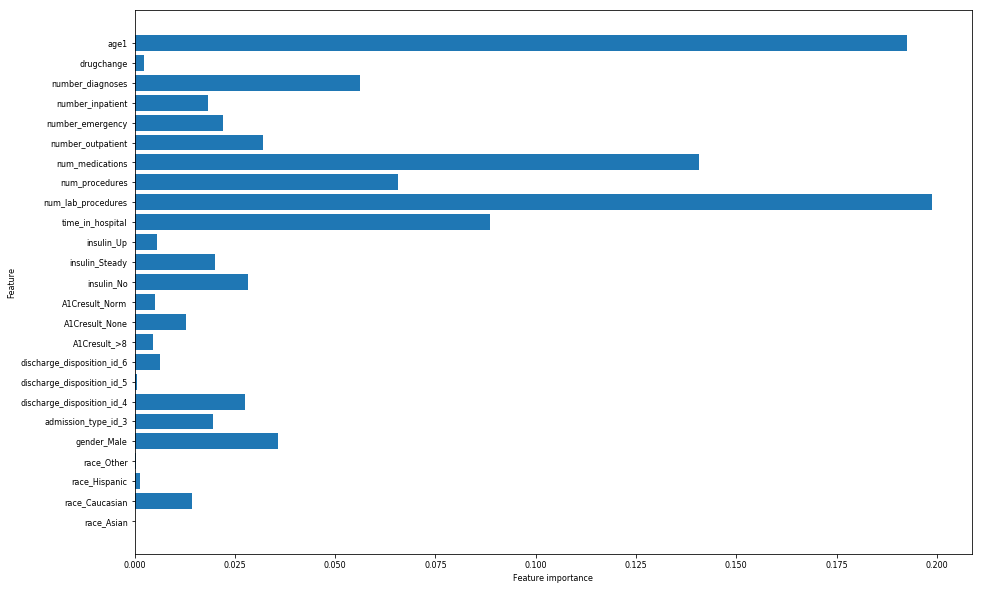

In [67]:
plot_feature_importances(xgbclassifier, xgbX_train)

### Results

In [61]:
#Using Shapely Additive Explainations to visualize which features had the 
#largest impact on predicted outcome.

shap.initjs()

explainer = shap.TreeExplainer(xgbclassifier)
shap_values = explainer.shap_values(xgbX_train)

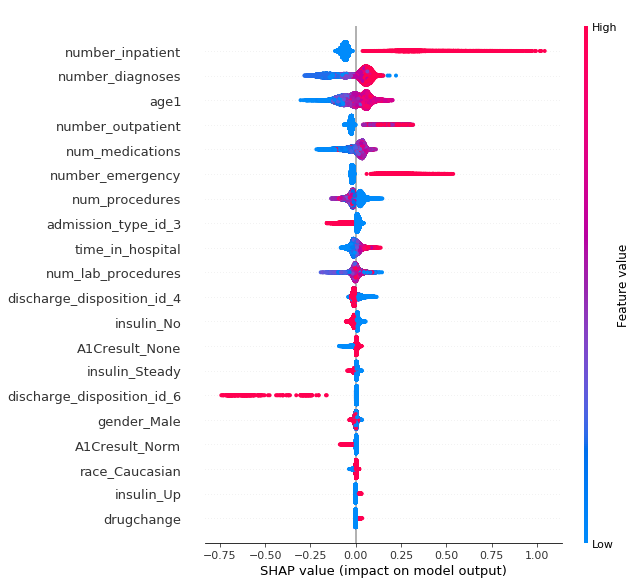

In [63]:
shap.summary_plot(shap_values, xgbX_train)

#### Conclusion

The final model with the best performance is that which has the highest AUC score. This was a tie between the Random Forest classifier with an AUC of .646 and the XGBoosted forest which had an AUC score of .644. This can be interpreted as the models having little class separability. 

For both the RF and XGB models, we got weighted average recall scores of .63, which means 63% of all classes were correctly predicted. The recall for the Non-Readmits, our '0' class was much higher (approx. 89%), while the recall for the Readmits ('1's) was much lower (approx. 25% for the XGB). That means we were more likely to label a patient as a non-readmit even if they were likely to return. Since 'Readmit' was our negative class, this means our False Negative rate was quite high.

Between the low recall score for the Readmit class and the relatively weak performance of the models, the predictive power of the models would be moderate if new data were introduced. Because there were only two classes for our target, even our optimized models only faired slightly better than random guessing(50% random vs. 64% for the models).

Additional features could potentially increase the predictive power of models, or understanding which types of diabetes the patients had. Age was somewhat randomized, so getting accurate data on that could also boost the models slightly.

There was additional data in the original set that described the discharge diagnosis of patients. The data was initially uncoded, so given more time, I could sequence that information as well.

It also seems like using modeling to predict long term health outcomes for patients can be difficult given the variance in human health and response to treatments.